# Entropy-regularized Contextual Dropout

## Environment Setup 

In [2]:
%conda install numpy matplotlib tqdm pytorch torchvision

Channels:
 - defaults
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /Users/a/.pyenv/versions/anaconda3-2024.10-1/envs/project

  added / updated specs:
    - matplotlib
    - numpy
    - pytorch
    - torchvision
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.2.25  |       hecd8cb5_0         131 KB
    certifi-2025.4.26          |  py312hecd8cb5_0         157 KB
    matplotlib-3.9.2           |  py312hecd8cb5_1           8 KB
    openssl-3.0.16             |       h184c1cd_0         4.6 MB
    pytorch-2.3.1              |cpu_py312hf01ac55_0        61.4 MB
    torchvision-0.18.1         |cpu_py312h937ada3_0         9.5 MB
    tqdm-4.67.1                |  py312h8e4b320_0         160 KB
    ------------------------------------------------------------
                                           Total:        75.9 MB

In [1]:
from typing import Callable

import torch
import torch.nn as nn            # neural network modules
import torch.nn.functional as F  # activation functions
import torch.optim as optim      # optimizer
import torch.utils.data          # dataloader
import torchvision.datasets as datasets

import numpy as np
import matplotlib.pyplot as plt
import tqdm

torch.manual_seed(42)

We will use MNIST as the benchmark as in the reference paper (see Appendix C1).

In [2]:
# Download the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# Load into torch datasets
train_dataset = torch.utils.data.TensorDataset(mnist_train.data.unsqueeze(1).float(), mnist_train.targets.long())
test_dataset = torch.utils.data.TensorDataset(mnist_test.data.unsqueeze(1).float(), mnist_test.targets.long())


## Contextual Dropout Modules

We implement contextual dropout in two parts:

* The module `ContextualDropoutMask` is a neural net
computing the dropout mask for an input $x$
as a function of $x$. 

* The function `EntropyRegularizer` is used as a regularizer 
during training to train the contextual dropout neural net. 

In [9]:
class ContextualDropoutMask(nn.Module):
    def __init__(
        self,
        input_dim,
        bottleneck_factor = 10, # the \gamma in the paper
        activation_fn: Callable = F.gelu,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = input_dim // bottleneck_factor + 1
        self.activation_fn = activation_fn

        self.w1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.w2 = nn.Linear(self.hidden_dim, self.input_dim) # output dim must match input

    def forward(self, x):
        x = self.w1(x)
        x = self.activation_fn(x)

        logits = self.w2(x)
        # transform to probabilities mask
        mask = F.sigmoid(logits)
        return mask

In [ ]:
class EntropyRegularizer(nn.Module):
    """
    Computes the regularization loss
    using relative entropy
    with respect to a Bernoulli distribution
    with probability p_target
    """
    def __init__(
            self,
            p_target,
            eps=1e-8 # must specify some precision or it'll bug out #TODO maybe unnecessary with builtin nn.BCELoss?
    ):
        super().__init__()
        self.p_target = p_target
        self.cross_entropy = nn.BCELoss()

    def forward(self, p):
        # the target map
        target = torch.full_like(p, self.p_target)

        loss = self.cross_entropy(p, target)
        return loss




## Building the two networks

To measure performance against regular dropout,
we implement the same task with two neural networks
which only differ in the kind of dropout used.

In [ ]:
class SimpleMLP(nn.Module): # the control net
    def __init__(
        self,
        input_dim: int = 784,
        output_dim: int = 10,
        hidden_dim_list: list = [100, 100],
        activation_fn: Callable = F.gelu,
        dropout_prob: float = 0.2,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim_list = hidden_dim_list
        self.activation_fn = activation_fn
        self.dropout = torch.nn.Dropout(p = dropout_prob) # simple, global dropout

        self.hidden_layers = nn.ModuleList() # for the hidden layers, see https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
        current_dim = self.input_dim
        for dim in self.hidden_dim_list:
            self.hidden_layers.append(
                nn.Linear(current_dim, dim)
            )
            current_dim = dim
        self.last_layer = nn.Linear(current_dim, self.output_dim)

    def forward(self, x):
        # flatten the input for the MLP
        x = x.view(x.size(0), -1)
        if self.training:
            x = self.dropout(x)
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            if self.training:
                x = self.dropout(x)
            x = self.activation_fn(x)
        
        x = self.last_layer(x) 
        return x

In [ ]:
class ContextualDropoutMLP(nn.Module):
    def __init__(
        self,
        input_dim: int = 784,
        output_dim: int = 10,
        hidden_dim_list: list = [100, 100],
        activation_fn: Callable = F.gelu,
        dropout_prob: float = 0.2,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim_list = hidden_dim_list
        self.activation_fn = activation_fn
        self.dropout_prob = dropout_prob

        self.hidden_layers = nn.ModuleList() # for the hidden layers, see https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
        current_dim = self.input_dim
        for dim in self.hidden_dim_list:
            self.hidden_layers.append(
                nn.Linear(current_dim, dim)
            )
            current_dim = dim

        self.last_layer = nn.Linear(current_dim, self.output_dim)

        # haven't found a clean way to do this,
        # but we must store the losses for each dropout
        # computed during a forward pass.
        # we start by storing each dropout module:
        self.dropout_modules = nn.ModuleList()
        self.dropout_modules.append(
            ContextualDropoutMask(input_dim=self.input_dim)
        )
        for dim in self.hidden_dim_list:
            self.dropout_modules.append(
                ContextualDropoutMask(input_dim=dim)
            )
        # we now attach hooks to each dropout module:
        # see https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook
        self.dropout_losses = []
        for module in self.dropout_modules:
            module.register_forward_hook(self.hook_init())

    def hook_init(self):
        keep_p_target = 1.0 - self.dropout_prob
        loss_fn = EntropyRegularizer(p_target=keep_p_target)
        def hook(module, input, output):
            p = output
            loss = loss_fn(p)
            self.dropout_losses.append(loss)
        return hook


    def forward(self, x):
        # flatten the input for the MLP
        x = x.view(x.size(0), -1)
        self.dropout_losses = []
        if self.training:
            drop = self.dropout_modules[0]
            p = drop(x)
            mask = torch.bernoulli(p)
            x = x * mask
        for l, hidden_layer in enumerate(self.hidden_layers):
            x = hidden_layer(x)
            if self.training:
                drop = self.dropout_modules[l + 1]
                p = drop(x)
                mask = torch.bernoulli(p)
                x = x * mask
            x = self.activation_fn(x)
        x = self.last_layer(x) 
        return x

## Training

This training function is modified from the CNN from Problem 5 in the first assignment.

In [64]:
def plot_metrics(train_metrics, test_metrics, xlabel, ylabel, title):
    plt.plot(train_metrics, label="Training")
    plt.plot(test_metrics, label="Testing")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

def train(model, loss_fn, train_loader, test_loader, optimizer, epochs=5, lambda_dropout=1.0):
    """Train the model.
    Args:
        model: the model
        loss_fn: the loss function
        train_loader: the training data loader
        test_loader: the testing data loader
        optimizer: the optimizer
        epochs: the number of epochs to train
    Returns:
        train_losses: the training losses
        test_losses: the testing losses
    """
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    loop = tqdm.tqdm(range(1, epochs + 1))

    for epoch in loop:
        # train the model for one epoch
        train_loss, train_accuracy = train_epoch(model, loss_fn, train_loader, optimizer, lambda_dropout=lambda_dropout)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # test the model for one epoch
        test_loss, test_accuracy = test_epoch(model, loss_fn, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(train_loss=train_loss, test_loss=test_loss, train_accuracy=train_accuracy, test_accuracy=test_accuracy)
    return train_losses, test_losses, train_accuracies, test_accuracies


def train_epoch(model, loss_fn, train_loader, optimizer, lambda_dropout=1.0):
    """Train the model for one epoch.
    Args:
        model: the model
        loss_fn: the loss function
        train_loader: the training data loader
        optimizer: the optimizer
    Returns:
        train_loss: the loss of the epoch
    """
    model.train()  # set model to training mode
    total_train_loss = 0
    total_correct = 0
    total_samples = 0
    train_accuracy = 0

    for batch_idx, (data, target) in enumerate(train_loader): # Q: why do we care about batch_idx?
        optimizer.zero_grad()

        output = model(data)
        task_loss = loss_fn(output, target)

        # inelegant hack
        # to determine whether we're training
        # our module or the control
        if hasattr(model, 'dropout_losses') and model.dropout_losses:
            entropy_reg = sum(model.dropout_losses)
        else:
            entropy_reg = 0.0
        
        loss = task_loss + lambda_dropout * entropy_reg

        loss.backward()
        optimizer.step()

        # train_loss += loss.item()
        total_train_loss += loss.item() * data.size(0)

        _, predicted = torch.max(output.data, 1)

        total_correct += (predicted == target).sum().item()

        total_samples += target.size(0)

        # correct = sum([pred == actual for pred, actual in zip(predicted, target)]).item()
        # train_accuracy += correct / len(output)

    # batches = len(train_loader)
    train_loss = total_train_loss / total_samples
    train_accuracy = total_correct / total_samples

    return train_loss, train_accuracy

def test_epoch(model, loss_fn, test_loader):
    """Test the model for one epoch.
    Args:
        model: the model
        loss_fn: the loss function
        test_loader: the testing data loader
    Returns:
        test_loss: the loss of the epoch
    """
    model.eval()  # set model to evaluation mode
    total_test_loss = 0
    total_correct = 0
    total_samples = 0
    test_accuracy = 0

    with torch.no_grad():  # disable gradient calculation
        for data, target in test_loader:
            output = model(data)
            loss = loss_fn(output, target)

            total_test_loss += loss.item() * data.size(0)
            # test_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_correct += (predicted == target).sum().item()
            total_samples += target.size(0)

            # correct = sum([pred == actual for pred, actual in zip(predicted, target)]).item()
            # test_accuracy += correct / len(output)

        # batches = len(test_loader)
        test_loss = total_test_loss / total_samples
        test_accuracy = total_correct / total_samples

    return test_loss, test_accuracy

## Finding the best $\lambda$

The new loss function involves a hyperparameter $\lambda$,
which needs to be tuned.
We use a simple order-of-magnitude (logarithmic) grid search to find the best one for our task.

In [ ]:
batch_size = 128
learning_rate = 1e-3
epochs = 10
input_dim = 784
hidden_dim_list = [300, 100]
output_dim = 10

loss_fn = torch.nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle since we're looping this
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

lambda_exp_list = np.arange(-2.0, 1.6, 0.5) 
lambdas = 10 ** lambda_exp_list

best_acc = 0.0
best_lambda = lambdas[0]
for current_lambda in lambdas:
    model = ContextualDropoutMLP(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list, dropout_prob=0.2)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    train_losses_ctrl, test_losses_ctrl, train_accuracies_ctrl, test_accuracies_ctrl = train(model, loss_fn, train_loader, test_loader, optimizer, epochs=epochs, lambda_dropout=current_lambda)
    best_test_acc = np.max(test_accuracies_ctrl)
    if best_test_acc > best_acc:
        best_acc = best_test_acc
        best_lambda = current_lambda

    
print(f"best lambda: {best_lambda}")
print(best_lambda)

Epoch 10: 100%|██████████| 10/10 [03:15<00:00, 19.52s/it, test_accuracy=0.975, test_loss=0.136, train_accuracy=0.962, train_loss=47.6]

best lambda: 3.1622776601683795
3.1622776601683795


This returns $\lambda = 10^{1/2} \approx 3.16$, which will be used in what follows.

## Comparing performance

We now compare the performance of our model with that of the control.
We keep all comparable values the same.

### Our model:

Epoch 60: 100%|██████████| 60/60 [23:53<00:00, 23.89s/it, test_accuracy=0.98, test_loss=0.186, train_accuracy=0.974, train_loss=4.86] 


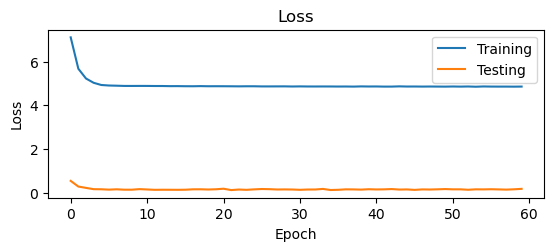

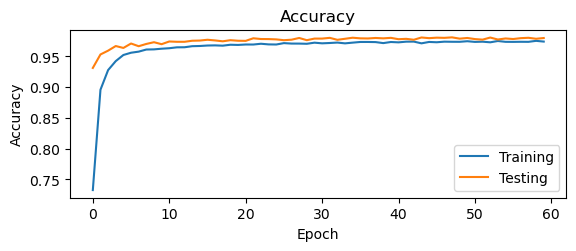

In [72]:
batch_size = 128
learning_rate = 1e-3
epochs = 60
input_dim = 784
hidden_dim_list = [300, 100]
output_dim = 10

model = ContextualDropoutMLP(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list, dropout_prob=0.2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_losses, test_losses, train_accuracies, test_accuracies = train(model, loss_fn, train_loader, test_loader, optimizer, epochs=epochs, lambda_dropout=best_lambda)

#save model
save_path = 'data/model.pth'
torch.save(model.state_dict(), save_path)

plt.subplot(2, 1, 1)
plot_metrics(train_losses, test_losses, xlabel="Epoch", ylabel="Loss", title="Loss")
plt.subplot(2, 1, 2)
plot_metrics(train_accuracies, test_accuracies, xlabel="Epoch", ylabel="Accuracy", title="Accuracy")

### The control:

Epoch 60: 100%|██████████| 60/60 [07:33<00:00,  7.56s/it, test_accuracy=0.979, test_loss=0.101, train_accuracy=0.972, train_loss=0.108] 


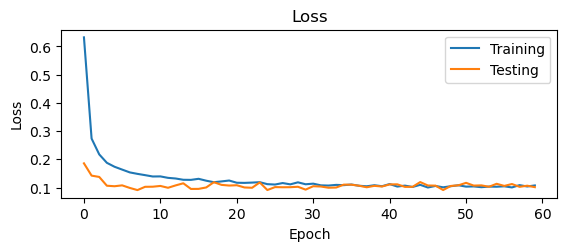

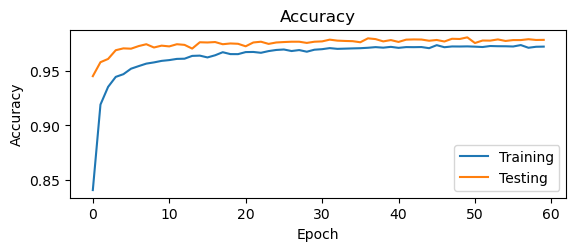

In [74]:
batch_size = 128
learning_rate = 1e-3
epochs = 60
input_dim = 784
hidden_dim_list = [300, 100]
output_dim = 10

model_ctrl = SimpleMLP(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list, dropout_prob=0.2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ctrl.parameters(), lr=learning_rate, weight_decay=1e-4)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_losses_ctrl, test_losses_ctrl, train_accuracies_ctrl, test_accuracies_ctrl = train(model_ctrl, loss_fn, train_loader, test_loader, optimizer, epochs=epochs, lambda_dropout=1.0)

#save model
save_path = 'data/model_ctrl.pth'
torch.save(model_ctrl.state_dict(), save_path)

plt.subplot(2, 1, 1)
plot_metrics(train_losses_ctrl, test_losses_ctrl, xlabel="Epoch", ylabel="Loss", title="Loss")
plt.subplot(2, 1, 2)
plot_metrics(train_accuracies_ctrl, test_accuracies_ctrl, xlabel="Epoch", ylabel="Accuracy", title="Accuracy")

### A closer look at the accuracy

It's not easy to see the difference in performance
between the two graphs.

First, the range is too wide, since 
the graph captures the accuracy curve since initialization.

Second, the curves are very jagged due to the sampling procedure.

To remedy the first point,
we restrict our data from the 20th epoch onward.

To remedy the second point,
we display moving averages of the accuracy
over a large enough window.

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (40).

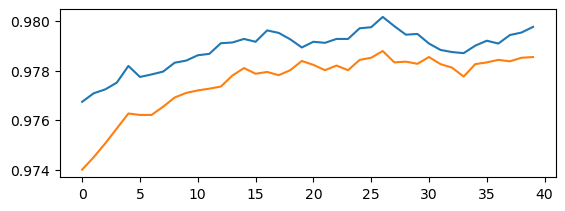

In [ ]:
display_start_epoch = 20

fit_acc = test_accuracies[display_start_epoch:]
fit_acc_ctrl = test_accuracies_ctrl[display_start_epoch:]

def moving_avg(arr, window_size):
    left_offset = window_size // 2
    right_offset = window_size - left_offset - 1
    padded_arr = [arr[0]] * left_offset + arr + [arr[-1]] * right_offset
    avgs = []
    for i, _ in enumerate(arr):
        window = padded_arr[i:i+window_size]
        avgs.append(np.average(window))
    return avgs

moving_avg_window_size = 7

fit_acc = moving_avg(fit_acc, moving_avg_window_size)
fit_acc_ctrl = moving_avg(fit_acc_ctrl, moving_avg_window_size)

ticks = np.arange(len(fit_acc))
epochs = ticks + display_start_epoch

ticks = [tick for tick in ticks if tick % 5 == 0]
epochs = [epoch for epoch in epochs if epoch % 5 == 0]


plt.subplot(2, 1, 1)
plt.plot(fit_acc, label="Model")
plt.plot(fit_acc_ctrl, label="Control")
plt.xticks(ticks=ticks, labels=epochs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Accuracy moving averages over {moving_avg_window_size} epochs")
plt.legend()
plt.show()

### Step 3: Improve the SimpleCNN

As you can see in the previous step, the training accuracy of the ``SimpleCNN`` is poor. In this step, you will improve the performance of the ``SimpleCNN`` by adding ``nn.MaxPool2d``, ``nn.Dropout``, and activation functions.

**Hint**: The max pooling layer is used to downsample the input along the spatial dimensions (width and height) independently for each channel. It is recommended to add the max pooling layer after the activation function.

In [8]:
class CNN(nn.Module):
    def __init__(
        self,
        input_dim: int = 1,
        output_dim: int = 10,
        hidden_dim_list: list = [4, 8],
        p: float = 0.0,
        act_fn: Callable = F.relu,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim_list = hidden_dim_list

        dim0 = hidden_dim_list[0]
        dim1 = hidden_dim_list[1]
        self.conv_1 = torch.nn.Conv2d(input_dim, dim0, 5, padding=2)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.conv_2 = torch.nn.Conv2d(dim0, dim1, 5, padding=2)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.fc = torch.nn.Linear(dim1 * 7 * 7, output_dim)
        self.act_fn = act_fn
        self.dropout = torch.nn.Dropout2d(p=p)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.dropout(x)
        x = self.act_fn(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.dropout(x)
        x = self.act_fn(x)
        x = self.pool_2(x)
        x = torch.nn.Flatten()(x)
        x = self.fc(x)
        return x

Again, use the training function and the same set of hyperparameters above to train your ``CNN`` on ``MNIST dataset``. You should get a training accuracy around 95%.

Epoch 10: 100%|██████████| 10/10 [02:14<00:00, 13.44s/it, test_accuracy=0.951, test_loss=0.164, train_accuracy=0.949, train_loss=0.17]


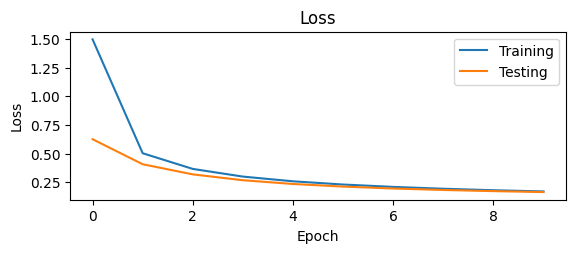

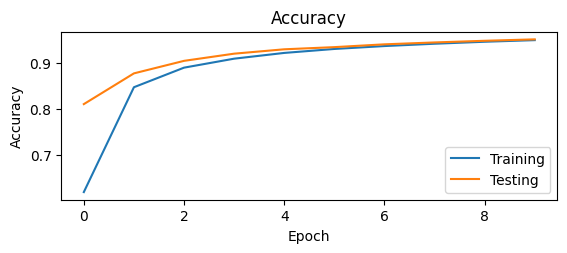

In [ ]:
batch_size = 64
learning_rate = 1e-4
epochs = 10
input_dim = 1
hidden_dim_list = [4, 8]
output_dim = 10
act_fn = F.relu
p = 0.0

model = CNN(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list, p=p, act_fn=act_fn)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_losses_ctrl, test_losses_ctrl, train_accuracies_ctrl, test_accuracies_ctrl = train(model, loss_fn, train_loader, test_loader, optimizer, epochs=epochs)

plt.subplot(2, 1, 1)
plot_metrics(train_losses_ctrl, test_losses_ctrl, xlabel="Epoch", ylabel="Loss", title="Loss")
plt.subplot(2, 1, 2)
plot_metrics(train_accuracies_ctrl, test_accuracies_ctrl, xlabel="Epoch", ylabel="Accuracy", title="Accuracy")

Here are the experiments:
- Try adjusting the learning rate to improve its accuracy. You might also try increasing the number of epochs used. Record your results in a table.
- Try training your network with different non-linearities between the layers (i.e. relu, softplus, elu, tanh). You should experiment with these and record your test results for each in a table
- Try changing the width of the hidden layer, keeping the activation function that performs best. Remember to add these results to your table.
- Experiment with the optimizer of your network (i.e. SGD, Adam, RMSProp). You should experiment with these and record your test results for each in a table

Epoch 10: 100%|██████████| 10/10 [02:35<00:00, 15.57s/it, test_accuracy=0.984, test_loss=0.0472, train_accuracy=0.982, train_loss=0.0561]


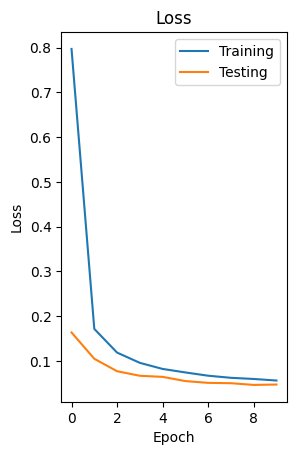

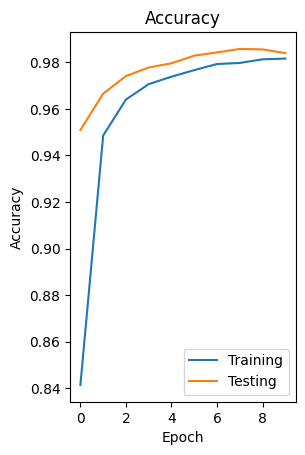

In [ ]:
batch_size = 64
learning_rate = 1e-3 * 0.5
epochs = 10
input_dim = 1
hidden_dim_list = [4, 8]
output_dim = 10
act_fn = F.gelu
p = 1e-2 * 5 # 5% dropout probability

model = CNN(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list, p=p, act_fn=act_fn)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_losses_ctrl, test_losses_ctrl, train_accuracies_ctrl, test_accuracies_ctrl = train(model, loss_fn, train_loader, test_loader, optimizer, epochs=epochs)

plt.subplot(1, 2, 1)
plot_metrics(train_losses_ctrl, test_losses_ctrl, xlabel="Epoch", ylabel="Loss", title="Loss")
plt.subplot(1, 2, 2)
plot_metrics(train_accuracies_ctrl, test_accuracies_ctrl, xlabel="Epoch", ylabel="Accuracy", title="Accuracy")

### Step 4: Hyperparameter Tuning

Now the interesting part begins. Try to improve the performance of your ``CNN`` by tuning the hyperparameters. You should be able to get a training accuracy around 98% and a validation accuracy around 97%.

Here are some new parameters you can try to improve the performance of your model:
- ``Optimizer (SGD, Adam, RMSProp, etc)``: Different optimizers may lead to different convergence speed and performance.
- ``Weight decay (L2 penalty)``: Weight decay is a regularization technique to prevent overfitting. It is recommended to use a small weight decay value (e.g., 1e-4).
- ``Activation function (ReLU, Leaky ReLU, Tanh, etc)``: Different activation functions may lead to different convergence speed and performance.
- ``Dropout rate``: Dropout is a regularization technique to prevent overfitting. It is recommended to use a small dropout rate (e.g., 0.2).
- ...

Please implement a grid search algorithm to find the best set of hyperparameters and report the best validation accuracy you can get. Any hyperparameter can be tuned!

Epoch 10: 100%|██████████| 10/10 [02:19<00:00, 13.99s/it, test_accuracy=0.973, test_loss=0.0828, train_accuracy=0.975, train_loss=0.08]


Final accuracy for model with learning rate 0.0001, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.0, and optimizer <class 'torch.optim.adam.Adam'>: 97.32285031847134%


Epoch 10: 100%|██████████| 10/10 [02:25<00:00, 14.57s/it, test_accuracy=0.975, test_loss=0.082, train_accuracy=0.975, train_loss=0.0795]


Final accuracy for model with learning rate 0.0001, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.01, and optimizer <class 'torch.optim.adam.Adam'>: 97.45222929936305%


Epoch 10: 100%|██████████| 10/10 [02:23<00:00, 14.32s/it, test_accuracy=0.978, test_loss=0.0665, train_accuracy=0.972, train_loss=0.0908]


Final accuracy for model with learning rate 0.0001, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.05, and optimizer <class 'torch.optim.adam.Adam'>: 97.78065286624204%


Epoch 10: 100%|██████████| 10/10 [02:33<00:00, 15.36s/it, test_accuracy=0.976, test_loss=0.0712, train_accuracy=0.977, train_loss=0.0749]


Final accuracy for model with learning rate 0.0001, activation function <built-in function gelu>, dropout probability 0.0, and optimizer <class 'torch.optim.adam.Adam'>: 97.64132165605095%


Epoch 10: 100%|██████████| 10/10 [02:39<00:00, 15.94s/it, test_accuracy=0.977, test_loss=0.0696, train_accuracy=0.979, train_loss=0.0704]


Final accuracy for model with learning rate 0.0001, activation function <built-in function gelu>, dropout probability 0.01, and optimizer <class 'torch.optim.adam.Adam'>: 97.65127388535032%


Epoch 10: 100%|██████████| 10/10 [02:39<00:00, 15.98s/it, test_accuracy=0.976, test_loss=0.072, train_accuracy=0.969, train_loss=0.0987]


Final accuracy for model with learning rate 0.0001, activation function <built-in function gelu>, dropout probability 0.05, and optimizer <class 'torch.optim.adam.Adam'>: 97.62141719745223%


Epoch 10: 100%|██████████| 10/10 [02:19<00:00, 13.91s/it, test_accuracy=0.98, test_loss=0.0631, train_accuracy=0.988, train_loss=0.0363]


Final accuracy for model with learning rate 0.0005, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.0, and optimizer <class 'torch.optim.adam.Adam'>: 97.98964968152866%


Epoch 10: 100%|██████████| 10/10 [02:22<00:00, 14.21s/it, test_accuracy=0.982, test_loss=0.0611, train_accuracy=0.985, train_loss=0.0466]


Final accuracy for model with learning rate 0.0005, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.01, and optimizer <class 'torch.optim.adam.Adam'>: 98.19864649681529%


Epoch 10: 100%|██████████| 10/10 [02:22<00:00, 14.21s/it, test_accuracy=0.98, test_loss=0.0591, train_accuracy=0.98, train_loss=0.0635]


Final accuracy for model with learning rate 0.0005, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.05, and optimizer <class 'torch.optim.adam.Adam'>: 98.04936305732484%


Epoch 10: 100%|██████████| 10/10 [02:31<00:00, 15.13s/it, test_accuracy=0.979, test_loss=0.0811, train_accuracy=0.989, train_loss=0.0378]


Final accuracy for model with learning rate 0.0005, activation function <built-in function gelu>, dropout probability 0.0, and optimizer <class 'torch.optim.adam.Adam'>: 97.88017515923568%


Epoch 10: 100%|██████████| 10/10 [02:36<00:00, 15.64s/it, test_accuracy=0.984, test_loss=0.057, train_accuracy=0.985, train_loss=0.0471]


Final accuracy for model with learning rate 0.0005, activation function <built-in function gelu>, dropout probability 0.01, and optimizer <class 'torch.optim.adam.Adam'>: 98.38773885350318%


Epoch 10: 100%|██████████| 10/10 [02:34<00:00, 15.40s/it, test_accuracy=0.983, test_loss=0.0536, train_accuracy=0.981, train_loss=0.0598]


Final accuracy for model with learning rate 0.0005, activation function <built-in function gelu>, dropout probability 0.05, and optimizer <class 'torch.optim.adam.Adam'>: 98.30812101910828%


Epoch 10: 100%|██████████| 10/10 [02:15<00:00, 13.51s/it, test_accuracy=0.977, test_loss=0.0903, train_accuracy=0.985, train_loss=0.0472]


Final accuracy for model with learning rate 0.001, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.0, and optimizer <class 'torch.optim.adam.Adam'>: 97.74084394904459%


Epoch 10: 100%|██████████| 10/10 [02:20<00:00, 14.00s/it, test_accuracy=0.982, test_loss=0.0606, train_accuracy=0.984, train_loss=0.051]


Final accuracy for model with learning rate 0.001, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.01, and optimizer <class 'torch.optim.adam.Adam'>: 98.22850318471338%


Epoch 10: 100%|██████████| 10/10 [02:17<00:00, 13.75s/it, test_accuracy=0.984, test_loss=0.0592, train_accuracy=0.98, train_loss=0.0649]


Final accuracy for model with learning rate 0.001, activation function <function relu at 0x7bfaa1c31b20>, dropout probability 0.05, and optimizer <class 'torch.optim.adam.Adam'>: 98.39769108280255%


Epoch 10: 100%|██████████| 10/10 [02:28<00:00, 14.84s/it, test_accuracy=0.98, test_loss=0.0724, train_accuracy=0.985, train_loss=0.0488]


Final accuracy for model with learning rate 0.001, activation function <built-in function gelu>, dropout probability 0.0, and optimizer <class 'torch.optim.adam.Adam'>: 98.00955414012739%


Epoch 10: 100%|██████████| 10/10 [02:31<00:00, 15.18s/it, test_accuracy=0.977, test_loss=0.0843, train_accuracy=0.984, train_loss=0.0507]


Final accuracy for model with learning rate 0.001, activation function <built-in function gelu>, dropout probability 0.01, and optimizer <class 'torch.optim.adam.Adam'>: 97.65127388535032%


Epoch 10: 100%|██████████| 10/10 [02:34<00:00, 15.44s/it, test_accuracy=0.976, test_loss=0.0734, train_accuracy=0.98, train_loss=0.0649]


Final accuracy for model with learning rate 0.001, activation function <built-in function gelu>, dropout probability 0.05, and optimizer <class 'torch.optim.adam.Adam'>: 97.61146496815286%
Best accuracy: 0.9839769108280255
Best model: CNN(
  (conv_1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=392, out_features=10, bias=True)
  (dropout): Dropout2d(p=0.05, inplace=False)
)


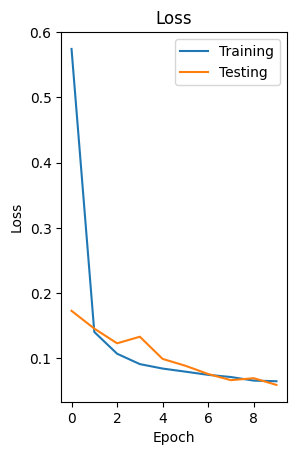

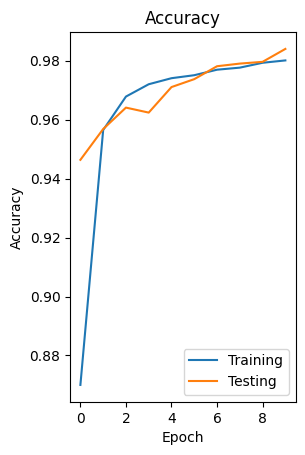

In [ ]:
# Grid search
batch_size = 64
learning_rate = [1e-4, 1e-3 * 0.5, 1e-3]
epochs = 10
input_dim = 1
hidden_dim_list = [4, 8]    # to save time, don't tune this
output_dim = 10
act_fn = [F.relu, F.gelu]
dropout_mask = [0.0, 0.01, 0.05]
optimizer_callable = [torch.optim.Adam]

loss_fn = torch.nn.CrossEntropyLoss()

best_accuracy = 0
best_model = None
best_history = None
save_path = '/best_model.pth'
for lr in learning_rate:
    for af in act_fn:
        for p in dropout_mask:
            for oc in optimizer_callable:
                # hyperparams = {'Learning rate': lr, 'Activation function': af, 'Dropout probability': p, 'Optimizer': oc}
                model = CNN(input_dim=input_dim, output_dim=output_dim, hidden_dim_list=hidden_dim_list, p=p, act_fn=af)
                optimizer = oc(model.parameters(), lr=lr, weight_decay=1e-4)
                history = train(model=model, loss_fn=loss_fn, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, epochs=epochs)
                acc = history[3][-1]
                print(f"Final accuracy for model with learning rate {lr}, activation function {af}, dropout probability {p}, and optimizer {oc}: {100 * acc}%")
                if acc > best_accuracy:
                    best_accuracy = acc
                    best_model = model
                    best_history = history
                    # save the best model's weights for good measure
                    torch.save(model.state_dict(), save_path)




print(f"Best accuracy: {best_accuracy}")
print(f"Best model: {best_model}")


plt.subplot(1, 2, 1)
plot_metrics(best_history[0], best_history[1], xlabel="Epoch", ylabel="Loss", title="Loss")
plt.subplot(1, 2, 2)
plot_metrics(best_history[2], best_history[3], xlabel="Epoch", ylabel="Accuracy", title="Accuracy")

### Step 5 Confusion Matrix
With your best performing model, plot a confusion matrix showing which digits were misclassified, and what they were misclassified as. What numbers are frequently confused with one another by your model?

In [20]:
from sklearn.metrics import confusion_matrix

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

dataiter = iter(test_loader)
data, target = next(dataiter)

model = CNN(input_dim=input_dim,
            output_dim=output_dim,
            hidden_dim_list=hidden_dim_list,
            p=0.05,
            act_fn=F.relu)
model.load_state_dict(torch.load(save_path))
model.eval()  # set model to evaluation mode

outputs = model(data)
_, predicted = torch.max(outputs, 1)

conf = confusion_matrix(target, predicted)

print("Confusion matrix for best performing model:")
print(conf)



<ipython-input-20-45dc9018cc49>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Confusion matrix for best performing model:
[[ 966    2    1    0    1    2    3    1    4    0]
 [   1 1130    0    1    1    0    1    0    1    0]
 [   1    4 1018    4    1    0    1    3    0    0]
 [   0    0    1  993    0   12    0    0    3    1]
 [   0    0    1    0  974    0    0    0    2    5]
 [   1    0    0    2    0  888    1    0    0    0]
 [   2    3    0    1    1   11  933    0    7    0]
 [   0    4   13    2    1    2    0 1001    2    3]
 [   1    0    2    1    0    4    0    0  964    2]
 [   1    3    0    1   11    6    0   12    3  972]]
